# Experiments with FHDpy

This notebook performs the two sets of experiments described in the preprint [arxiv preprint](https://arxiv.org/abs/2507.11406). For better comprehension, we strongly suggest the reader to check out the two tutorials (i.e., `TutorialSLP.ipynb` and `TutorialFHD.ipynb`) before using this notebook.

Each section can be run seperately.

Credits: Henrique Ennes (https://hlovisiennes.github.io/).

## Genus 1

In [1]:
import FHDpy.FHD as FHD
from FHDpy.SLP import SLP as SLP

import snappy

import time
import matplotlib.pyplot as plt
import numpy as np

For genus 1, we have a few options besides `FHDLong` to compute the homology of a Heegaard splitting given a gluing word. This can be done by `FHD_genus1` which already has a triangulation of the torus encoded and no arguments are necessary (in particular, provided the algorithm described by Stefankovic, one can compute the normal coordinates of the Heegaard diagram).

In [2]:
genus1 = FHD.FHD_genus1()
gluing = 'bAbaa' # This can be changed by the user to experiment with distinct 3-manifolds.
genus1.dehn_twist(gluing)
print('Beta curve: ', genus1.get_uncompressed().list_form[-1])
print('Homology: ', genus1.homology())

Beta curve:  b*.b.c.b.c.a.c.c*.b*.b.c.b.c.a.c.b.c.b.c.a.c.c*
Homology:  Z/3


And we can also use the canonical representation of $\text{Mod}(T^2)$ in $\text{GL}(\mathbb{R}^ 2)$ to compute the homology as $\mathbb{Z}/n$ where $n$ is the second coordinate of the vector we act upon.

In [3]:
print('Homology: ', FHD.modular_representation(gluing))

Homology:  Z/3


Of course, this can aslo be done using `SnapPy`'s `Twister` (with or without an optimization step in which tetrahedra are greedly folded to decrease the size of the triangulation) or using FHDLong.

In [5]:
torus = snappy.twister.Surface('S_1')
manifold_optimized = torus.splitting(gluing= gluing, handles= 'a*A')
manifold_not_optimized = torus.splitting(gluing= gluing, handles= 'a*A', optimize = False)

# The cell structure defined below is *not* a triangulation of the torus, but only its usual fundamental polygon.
# Although normal coordinates are defined only for triangulations, for the kind
# of experiments of this notebook, a triangulation is not necessary, which allows us to use 
# standard curves in more general cellular structures. 
alpha_curves_standard = {'a': SLP(['b*'])}
alpha_curves_edges = {'a':['a']}
generators_standard = {'a': SLP(['b']), 'b': SLP(['a*'])}
generators_edge = {'a':['a'], 'b':['b']}

fhd_compressed = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
fhd_compressed.dehn_twist(gluing, compress = True)

fhd_not_compressed = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
fhd_not_compressed.dehn_twist(gluing, compress = False) # Does not optimize the Heegaard word by compressing it to power form.

print('Homology of snappy (optimization on):', manifold_optimized.homology())
print('Homology of snappy (optimization off):', manifold_not_optimized.homology())
print('FHD (compression on):', fhd_compressed.homology())
print('FHD (compression off):', fhd_not_compressed.homology())

Homology of snappy (optimization on): Z/3
Homology of snappy (optimization off): Z/3
FHD (compression on): Z/3
FHD (compression off): Z/3


### Gluing 'bA'*n

Recall that the gluing $(bA)^n$ yields to 3-manifolds of homology $\mathbb{Z}/f_{2n}$ where $f_i$ is the $i$-th entry of the Fibonacci sequence starting at $0$ (i.e., $\{0,1,1,2,3,\dots\}$. Let us compute some of these homologies by generating the Fibonacci sequence (with dynamic programing with memorization).

In [6]:
def fib(n):
    fib_list = [0,1]
    while len(fib_list) < n:
        fib_list.append(fib_list[-1] + fib_list[-2])
    
    return fib_list
homology_list = fib(1001)[0::2]

We can use that we know exactly the homology of the manifold with gluing $(bA)^n$ to check which of our methods is more robust.

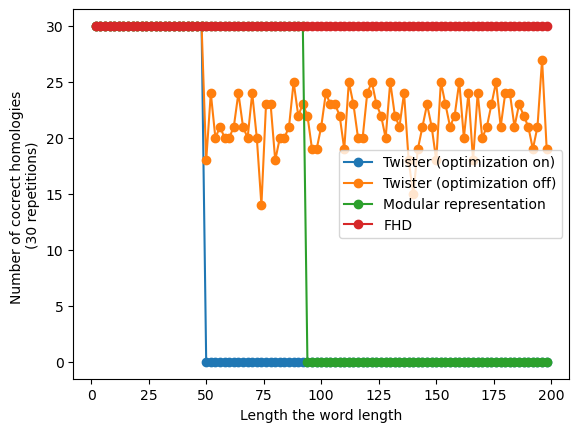

In [7]:
n_rep = 30 # Because of the folding, it there is some randomization in how often snappy 
# + optimization will get the right homology, so we will repeat the experiments n_rep times.
n_max = 100

twister = []
twister_no_optimization = []
modular = []
fhd = []

fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

for n in range(1,n_max):
    gluing = 'bA'*n
    real_homology = snappy.AbelianGroup([[homology_list[n]]])
    
    counter_us = 0
    counter_twister = 0
    counter_twister_no_optimization = 0
    counter_rep = 0
    
    for rep in range(n_rep):
        manifold_optimized = torus.splitting(gluing = gluing, handles= 'a*A')
        if manifold_optimized.homology() == real_homology: counter_twister += 1
        
        manifold_not_optimized=  torus.splitting(gluing = gluing, handles= 'a*A', optimize = False)
        if manifold_not_optimized.homology() == real_homology: counter_twister_no_optimization += 1
        
        if FHD.modular_representation(gluing) == real_homology: counter_rep += 1
        
        fhd_diagram.reset()
        fhd_diagram.dehn_twist(gluing, compress = False)
        if fhd_diagram.homology() == real_homology: counter_us += 1
        
        
        
    twister.append(np.sum(counter_twister))
    twister_no_optimization.append(np.sum(counter_twister_no_optimization))
    modular.append(np.sum(counter_rep))
    fhd.append(np.sum(counter_us))
    
        
plt.plot(2*np.array(range(1,n_max)), twister, '-o', label = 'Twister (optimization on)')
plt.plot(2*np.array(range(1,n_max)), twister_no_optimization, '-o', label = 'Twister (optimization off)')
plt.plot(2*np.array(range(1,n_max)), modular, '-o', label = 'Modular representation')
plt.plot(2*np.array(range(1,n_max)), fhd, '-o', label = 'FHD')

plt.xlabel('Length the word length')
plt.ylabel('Number of cocrect homologies \n(' + str(n_rep) + ' repetitions)')

plt.legend()
plt.show()

Interestingly, we are more numerical stable than `numpy` for this specific problem. Refer to the paper for a discussion on this matter.

### Gluing 'b'^n

We now explore gluing by $b^n$. This example is interesting because it uses the full power of `FHD` by compressing the word $b\cdot b\cdot b\cdot\dots\cdot b$ into power notation, which can then be executed in only $O(\log(|w|^2))$ instead of $O(|w|^2)$ when the word is not compressed, where $|w|$ is the length of the Heegaard word. We note that, as implemented, the compression takes time $O(|w|)$, so the overall complexity of the problem is only $O(|w|)$.

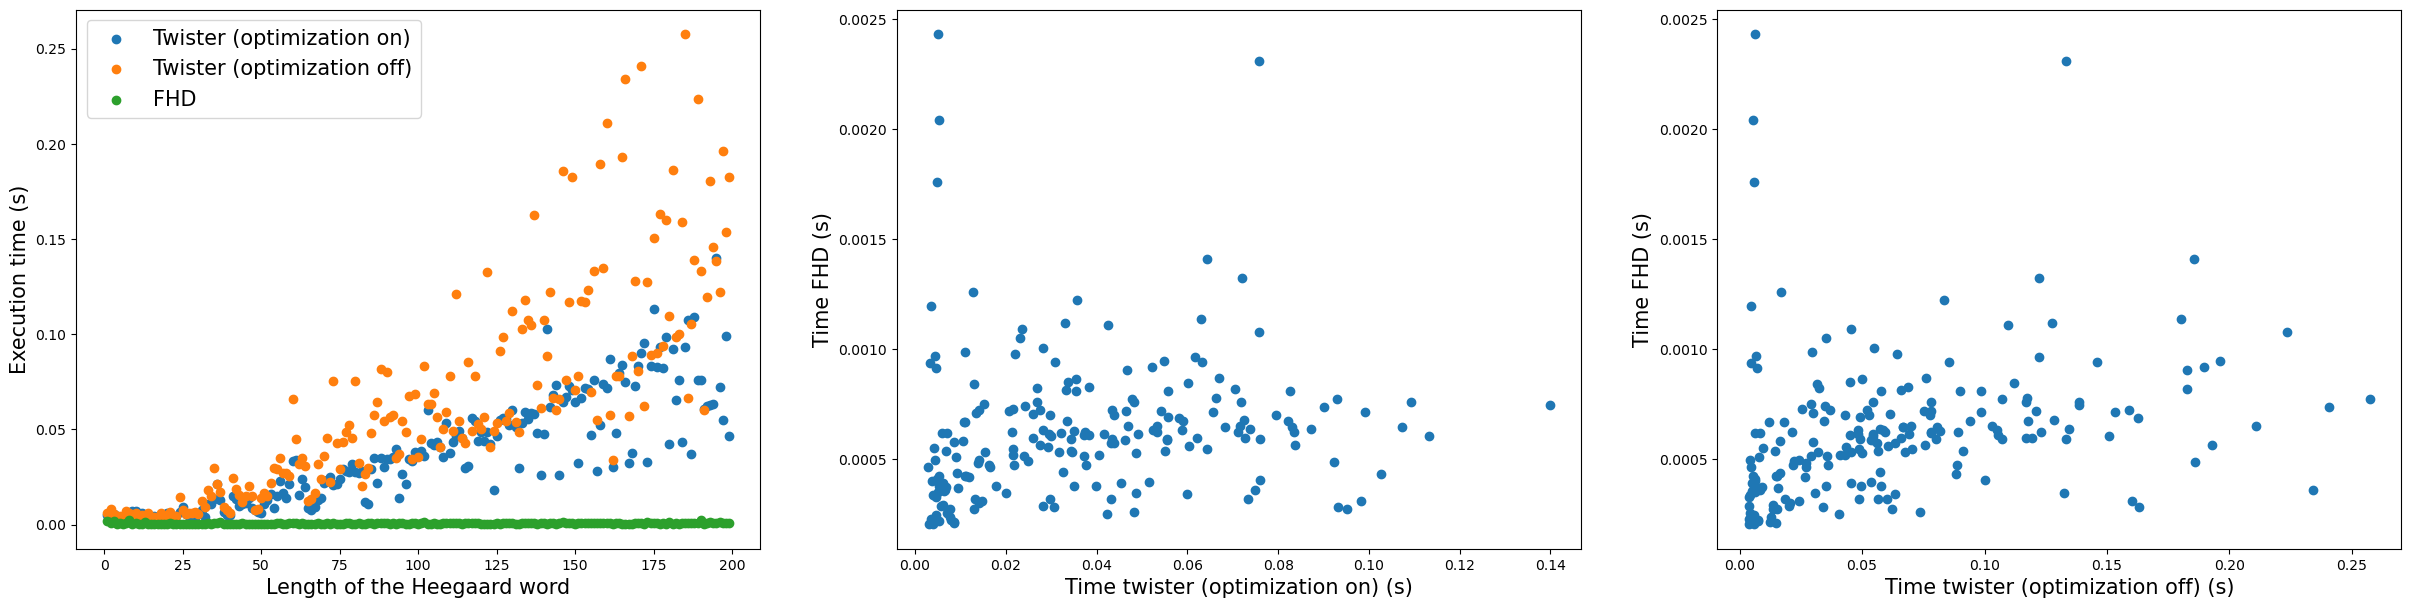

In [8]:
n_max = 200

time_twister = []
time_twister_no_optimization = []
time_fhd = []

fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

for n in range(1,n_max):
    gluing = 'b'*n
    
    start = time.time()
    manifold_optimized = torus.splitting(gluing = gluing, handles= 'a*A')
    manifold_optimized.homology()
    end = time.time()
    time_twister.append(end-start)

    start = time.time()
    manifold_not_optimized = torus.splitting(gluing = gluing, handles= 'a*A', optimize = False)
    manifold_not_optimized.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)

    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = True)
    fhd_diagram.homology()
    end = time.time()
    time_fhd.append(end-start)    


fig, axs = plt.subplots(1,3, figsize = (30,7))

axs[0].scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
axs[0].scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
axs[0].scatter(range(1,n_max), time_fhd, label = 'FHD')
axs[0].legend(fontsize = 15)
axs[0].set_xlabel('Length of the Heegaard word', fontsize = 15)
axs[0].set_ylabel('Execution time (s)', fontsize = 15)

axs[1].scatter(time_twister, time_fhd)
axs[1].set_xlabel( 'Time twister (optimization on) (s)', fontsize = 15)
axs[1].set_ylabel('Time FHD (s)', fontsize = 15)

axs[2].scatter(time_twister_no_optimization, time_fhd)
axs[2].set_xlabel( 'Time twister (optimization off) (s)', fontsize = 15)
axs[2].set_ylabel('Time FHD (s)', fontsize = 15)

plt.show()

Now we experiment with the gluing map already in power notation form. This time, the gain of `FHD` over `Twister` is expected to be exponential.

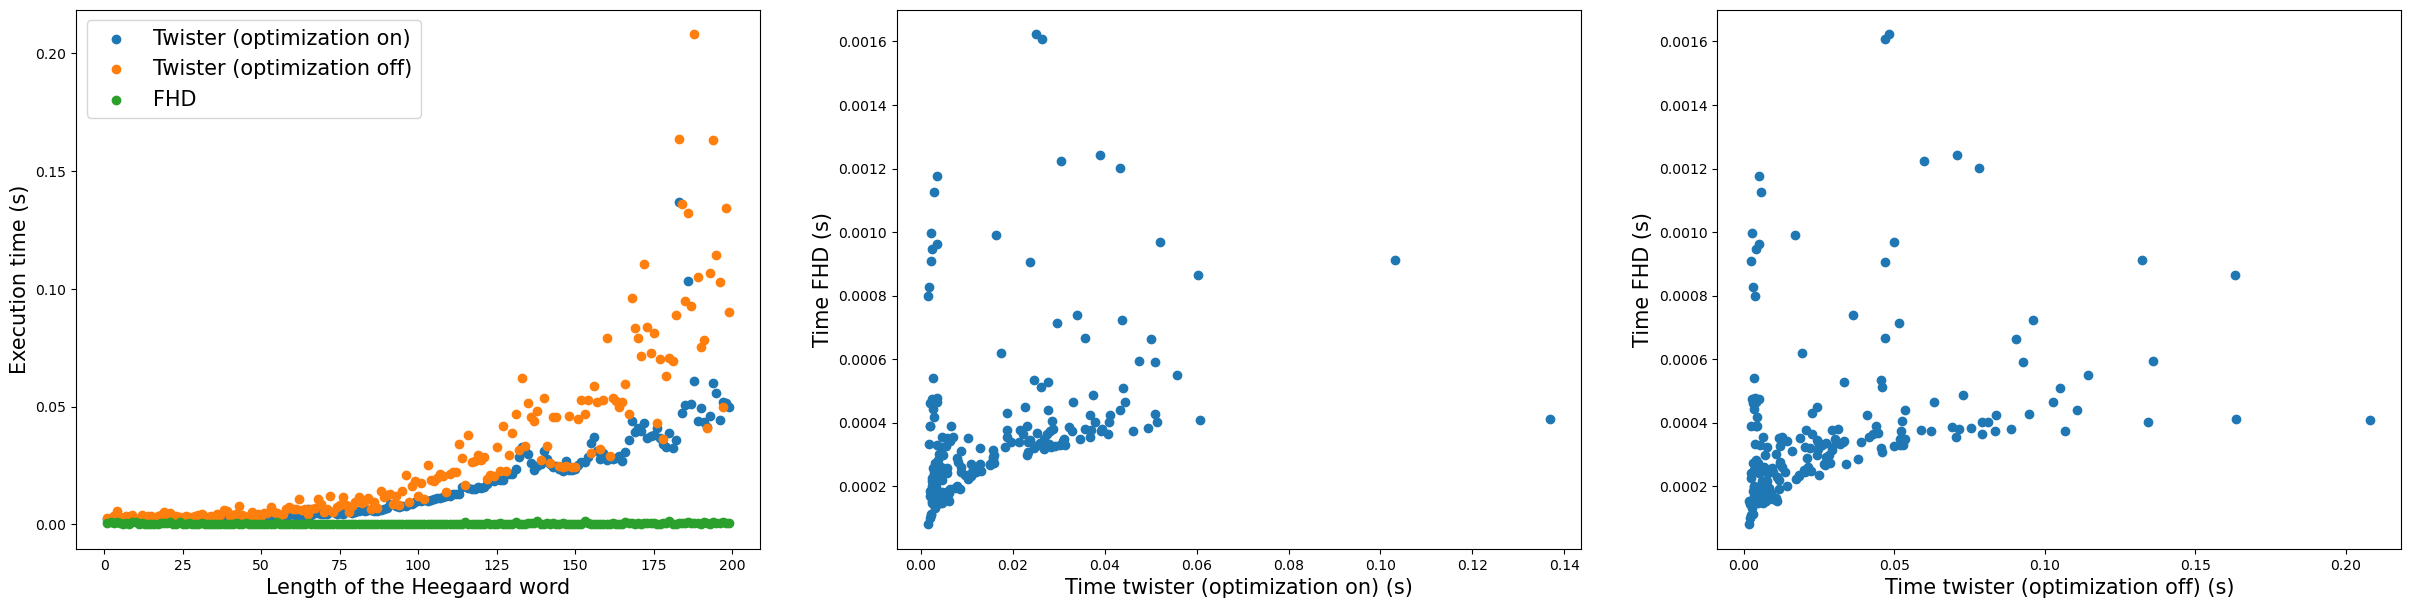

In [9]:
n_max = 200

time_twister = []
time_twister_no_optimization = []
time_fhd = []

fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

for n in range(1,n_max):
    gluing = 'b'*n
    gluing_compressed = 'b^' + str(n)
    
    start = time.time()
    manifold_optimized = torus.splitting(gluing = gluing, handles= 'a*A')
    manifold_optimized.homology()
    end = time.time()
    time_twister.append(end-start)

    start = time.time()
    manifold_not_optimized = torus.splitting(gluing = gluing, handles= 'a*A', optimize = False)
    manifold_not_optimized.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)

    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing_compressed, compress = False)
    fhd_diagram.homology()
    end = time.time()
    time_fhd.append(end-start)    


fig, axs = plt.subplots(1,3, figsize = (30,7))

axs[0].scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
axs[0].scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
axs[0].scatter(range(1,n_max), time_fhd, label = 'FHD')
axs[0].legend(fontsize = 15)
axs[0].set_xlabel('Length of the Heegaard word', fontsize = 15)
axs[0].set_ylabel('Execution time (s)', fontsize = 15)

axs[1].scatter(time_twister, time_fhd)
axs[1].set_xlabel( 'Time twister (optimization on) (s)', fontsize = 15)
axs[1].set_ylabel('Time FHD (s)', fontsize = 15)

axs[2].scatter(time_twister_no_optimization, time_fhd)
axs[2].set_xlabel( 'Time twister (optimization off) (s)', fontsize = 15)
axs[2].set_ylabel('Time FHD (s)', fontsize = 15)

plt.show()

### Random gluing

Now we experiment with random words generated by `SnapPy`'s `random_word` module. For comparison, we use both FHD with and without compression.

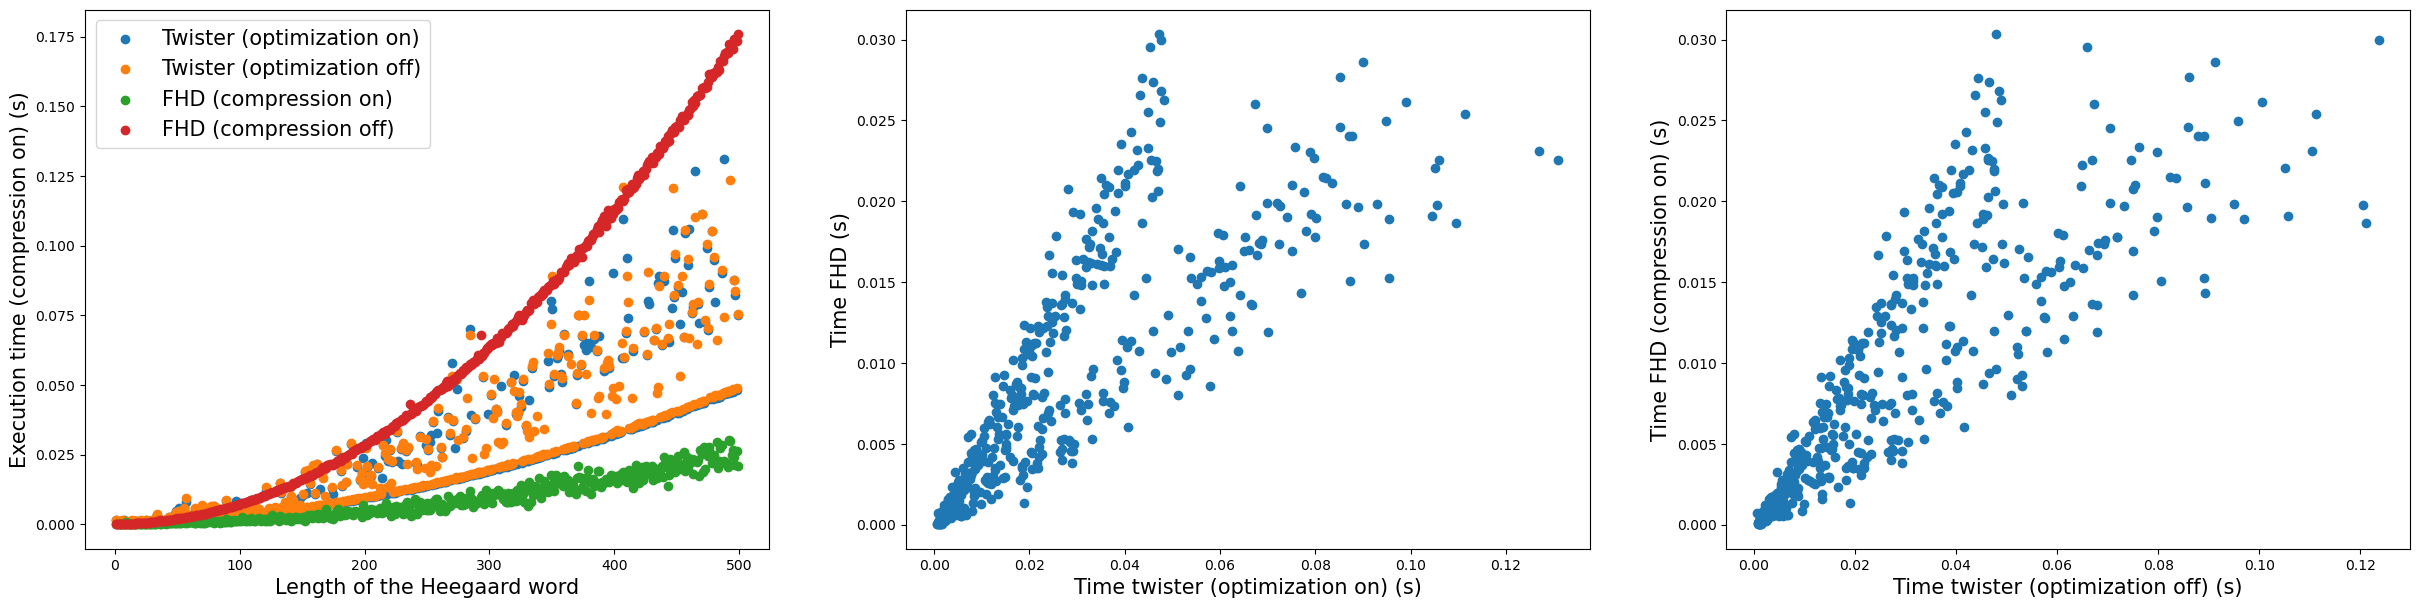

In [ ]:
n_max = 500

time_twister = []
time_twister_no_optimization = []
time_fhd = []
time_fhd_no_compression = []


fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

for n in range(1,n_max):
    gluing = torus.random_word(n)
    
    start = time.time()
    manifold_optimized = torus.splitting(gluing = gluing, handles= 'a*A')
    manifold_optimized.homology()
    end = time.time()
    time_twister.append(end-start)

    start = time.time()
    manifold_not_optimized = torus.splitting(gluing = gluing, handles= 'a*A', optimize = False)
    manifold_not_optimized.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)

    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = True)
    fhd_diagram.homology()
    end = time.time()
    time_fhd.append(end-start) 
    
    
    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = False)
    fhd_diagram.homology()
    end = time.time()
    time_fhd_no_compression.append(end-start) 


fig, axs = plt.subplots(1,3, figsize = (30,7))

axs[0].scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
axs[0].scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
axs[0].scatter(range(1,n_max), time_fhd, label = 'FHD (compression on)')
axs[0].scatter(range(1,n_max), time_fhd_no_compression, label = 'FHD (compression off)')
axs[0].legend(fontsize = 15)
axs[0].set_xlabel('Length of the Heegaard word', fontsize = 15)
axs[0].set_ylabel('Execution time (compression on) (s)', fontsize = 15)

axs[1].scatter(time_twister, time_fhd)
axs[1].set_xlabel( 'Time twister (optimization on) (s)', fontsize = 15)
axs[1].set_ylabel('Time FHD (s)', fontsize = 15)

axs[2].scatter(time_twister_no_optimization, time_fhd)
axs[2].set_xlabel( 'Time twister (optimization off) (s)', fontsize = 15)
axs[2].set_ylabel('Time FHD (compression on) (s)', fontsize = 15)

plt.show()

Notice that we are still often faster than `SnapPy`'s `Twister`. This happens because the mapping class group of the torus has only 2 generators, so compressions are often possible. Moreover, while `Twister` is implemented in $\texttt{C}++$, `FHD`'s implementations uses only $\texttt{Python}$.

## Genus 2

In [4]:
import FHDpy.FHD as FHD
from FHDpy.SLP import SLP as SLP

import snappy

import matplotlib.pyplot as plt

import time

We now explore the case of genus 2. Here, our only tool is `FHDLong`. The cellular structure assumed is 

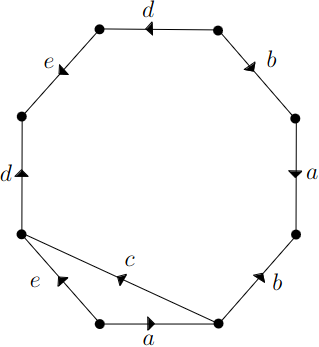

In [2]:
double_torus = snappy.twister.Surface('S_2')

# Cellular structure of the double torus, see the diagram above.
alpha_curves_standard = {'a': SLP(['b']), 'e': SLP(['d*'])}
alpha_curves_edges = {'a':['a'], 'e':['e']}
generators_standard = {'a': SLP(['b*']), 
                       'b': SLP(['c*','a','#0.#1']), 
                       'c': SLP(['b','d','#0.#1']),
                       'd': SLP(['c*','e*','#0.#1']), 
                       'e': SLP(['d'])}
generators_edge = {'a':['a'], 'b':['b'], 'c':['c'], 'd':['d'], 'e':['e']}

gluing = double_torus.random_word(10)

print('Gluing: ', gluing)

manifold_optimized = double_torus.splitting(gluing = gluing, handles= 'a*e*A*E')

manifold_not_optimized = double_torus.splitting(gluing = gluing, handles= 'a*e*A*E', optimize = False)

fhd_compressed = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
fhd_compressed.dehn_twist(gluing, compress = True)

fhd_not_compressed = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
fhd_not_compressed.dehn_twist(gluing) 

print('Homology of snappy (optimization on):', manifold_optimized.homology())
print('Homology of snappy (optimization off):', manifold_not_optimized.homology())
print('FHD (compression on):', fhd_compressed.homology())
print('FHD (compression off):', fhd_not_compressed.homology())

Gluing:  dedEEBEbeD
Homology of snappy (optimization on): Z
Homology of snappy (optimization off): Z
FHD (compression on): Z
FHD (compression off): Z


### Speed comparison

In [3]:
n_max = 500

time_twister = []
time_twister_no_optimization = []
time_fhd = []
time_fhd_no_compression = []


fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

for n in range(1,n_max):
    gluing = double_torus.random_word(n)
    
    start = time.time()
    manifold_optimized = double_torus.splitting(gluing = gluing, handles= 'a*e*A*E')
    manifold_optimized.homology()
    end = time.time()
    time_twister.append(end-start)

    start = time.time()
    manifold_not_optimized = double_torus.splitting(gluing = gluing, handles= 'a*e*A*E', optimize = False)
    manifold_not_optimized.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)

    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = True)
    fhd_diagram.homology()
    end = time.time()
    time_fhd.append(end-start) 
    
    
    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = False)
    fhd_diagram.homology()
    end = time.time()
    time_fhd_no_compression.append(end-start) 
    


fig, axs = plt.subplots(1,3, figsize = (30,7))

axs[0].scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
axs[0].scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
axs[0].scatter(range(1,n_max), time_fhd, label = 'FHD (compression on)')
axs[0].scatter(range(1,n_max), time_fhd_no_compression, label = 'FHD (compression off)')
axs[0].legend(fontsize = 15)
axs[0].set_xlabel('Length of the Heegaard word', fontsize = 15)
axs[0].set_ylabel('Execution time (compression on) (s)', fontsize = 15)

axs[1].scatter(time_twister, time_fhd)
axs[1].set_xlabel( 'Time twister (optimization off) (s)', fontsize = 15)
axs[1].set_ylabel('Time FHD (compression on) (s)', fontsize = 15)

axs[2].scatter(time_twister_no_optimization, time_fhd)
axs[2].set_xlabel( 'Time twister (optimization off) (s)', fontsize = 15)
axs[2].set_ylabel('Time FHD (compression on) (s)', fontsize = 15)

plt.show()

NameError: name 'time' is not defined

### Frequency of Haken manifolds and homology spheres

We now compute the rate of occurences of homology spheres and guaranteed Haken manifolds (i.e., by looking for positive Betti number manifolds) by sampling uniformly Heegaard words of variable lengths for fixed genus 2.

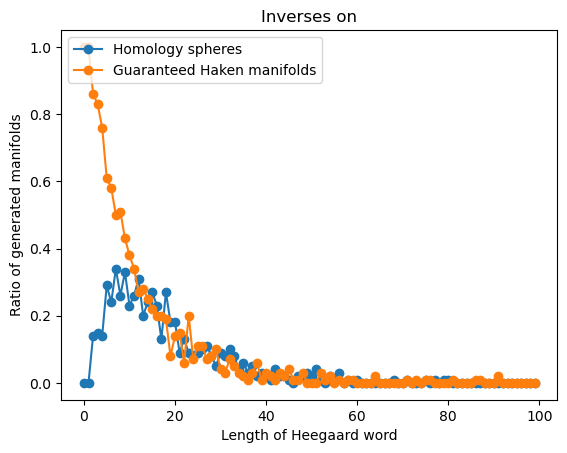

In [ ]:
double_torus = snappy.twister.Surface('S_2')

alpha_curves_standard = {'a': SLP(['b']), 'e': SLP(['d*'])}
alpha_curves_edges = {'a':['a'], 'e':['e']}
generators_standard = {'a': SLP(['b*']), 
                       'b': SLP(['c*','a','#0.#1']), 
                       'c': SLP(['b','d','#0.#1']),
                       'd': SLP(['c*','e*','#0.#1']), 
                       'e': SLP(['d'])}
generators_edge = {'a':['a'], 'b':['b'], 'c':['c'], 'd':['d'], 'e':['e']}

fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

reps = 100
n_max = 100

homology_spheres = []
haken = []

for n in range(0,n_max):
    counter_homology_spheres = 0
    counter_haken = 0
    for _ in range(reps):
        gluing = double_torus.random_word(n)
        
        fhd_diagram.reset()
        fhd_diagram.dehn_twist(gluing, compress = True)

        if fhd_diagram.homology() == snappy.AbelianGroup([[1]]): 
            counter_homology_spheres += 1
        if fhd_diagram.homology().betti_number() > 0:
            counter_haken += 1
    
    homology_spheres.append(counter_homology_spheres/reps)
    haken.append(counter_haken/reps)

plt.plot(range(0,n_max), homology_spheres, 'o-', label = 'Homology spheres')
plt.plot(range(0,n_max), haken, 'o-', label = 'Guaranteed Haken manifolds')
plt.legend(loc =  'upper left')
plt.xlabel('Length of Heegaard word')
plt.ylabel('Ratio of generated manifolds')
plt.title('Inverses on')

plt.show()

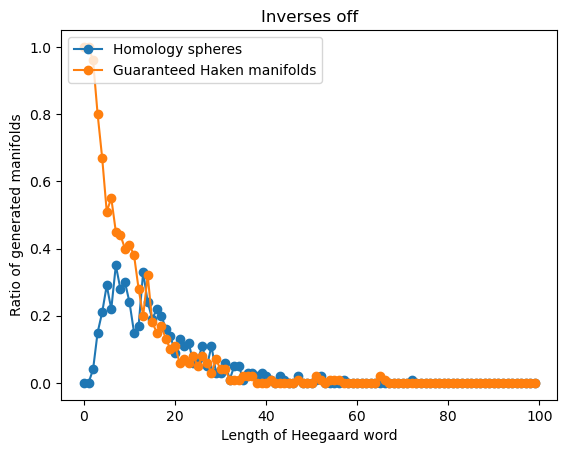

In [ ]:
reps = 100
n_max = 100

homology_spheres = []
haken = []

for n in range(0,n_max):
    counter_homology_spheres = 0
    counter_haken = 0
    for _ in range(reps):
        gluing = double_torus.random_word(n, inverses = False)
        
        fhd_diagram.reset()
        fhd_diagram.dehn_twist(gluing, compress = True)

        if fhd_diagram.homology() == snappy.AbelianGroup([[1]]): 
            counter_homology_spheres += 1
        if fhd_diagram.homology().betti_number() > 0:
            counter_haken += 1
    
    homology_spheres.append(counter_homology_spheres/reps)
    haken.append(counter_haken/reps)

plt.plot(range(0,n_max), homology_spheres, 'o-', label = 'Homology spheres')
plt.plot(range(0,n_max), haken, 'o-', label = 'Guaranteed Haken manifolds')

plt.legend(loc =  'upper left')
plt.xlabel('Length of Heegaard word')
plt.ylabel('Ratio of generated manifolds')
plt.title('Inverses off')


plt.show()

### Linear model for the order of the homology groups

The random Heegaard splitting model asymptotically gives rational homology spheres with torsion [Dunfield and Thurston, 2006], that is, of zero Betti number, but with $H_1$ finite. 
In particular, [Rivin, 2014] shows that the random variable $\overline{H_1^n}=\frac{1}{n}\sum_{i=1}^N \log|H_1((\Sigma_g,\psi_n^i(\alpha)))|$ where $(\psi_n)_{i=1}^N\overset{\mathrm{iid}}{\sim}\text{Uniform}(B(n))$ follows a Central Limit Theorem
\begin{equation*}
    \frac{1}{\sqrt{N}}(\overline{H_1^n}-n\lambda)\to \mathcal{N}(0,\sigma^2)
\end{equation*}
for some positive constants $\sigma$ and $\lambda$, as $N\to \infty$ (restricted to cases where $\log|H_1((\Sigma_g,\psi_n^i(\alpha)))|$ is finite). 

In [ ]:
reps = 30
n_max = 500

average_orders = []

for n in range(10,n_max):
    average_order = 0
    w = 0
    while w < reps:
        gluing = double_torus.random_word(n)
        
        fhd_diagram.reset()
        fhd_diagram.dehn_twist(gluing, compress = True)

        if (type(fhd_diagram.homology().order()) == int) and (fhd_diagram.homology().order() > 0):
            average_order += math.log(fhd_diagram.homology().order())
            w += 1
       
    
    average_orders.append(average_order/reps)

plt.scatter(range(10,n_max), average_orders, c = 'darkred')
plt.xlabel(r'$n$')
plt.ylabel(r'Average of the log of the order of $H_1$')

plt.show()